In [75]:
import numpy as np
from numpy.polynomial.polynomial import polyval as npp_polyval
from scipy import signal
from scipy import special, optimize, fft as sp_fft
import operator
import matplotlib.pyplot as plt
from scipy.io import wavfile
import math
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20, 16)


In [76]:
def _is_int_type(x):
    """
    Check if input is of a scalar integer type (so ``5`` and ``array(5)`` will
    pass, while ``5.0`` and ``array([5])`` will fail.
    """
    if np.ndim(x) != 0:
        # Older versions of NumPy did not raise for np.array([1]).__index__()
        # This is safe to remove when support for those versions is dropped
        return False
    try:
        operator.index(x)
    except TypeError:
        return False
    else:
        return True


In [77]:
def freqz(b, a=1, worN=512, fs=2*np.pi):
    b = np.atleast_1d(b)
    a = np.atleast_1d(a)

    if worN is None:
        # For backwards compatibility
        worN = 512

    h = None

    if _is_int_type(worN):
        N = operator.index(worN)
        del worN
        if N < 0:
            raise ValueError('worN must be nonnegative, got %s' % (N,))
        lastpoint = np.pi
        # if include_nyquist is true and whole is false, w should include end point
        w = np.linspace(0, lastpoint, N, endpoint=False)
        if (a.size == 1 and N >= b.shape[0] and
                sp_fft.next_fast_len(N) == N and
                (b.ndim == 1 or (b.shape[-1] == 1))):
            # if N is fast, 2 * N will be fast, too, so no need to check
            n_fft = N * 2
            if np.isrealobj(b) and np.isrealobj(a):
                fft_func = sp_fft.rfft
            else:
                fft_func = sp_fft.fft
            h = fft_func(b, n=n_fft, axis=0)[:N]
            h /= a
            if fft_func is sp_fft.rfft and False:
                # exclude DC and maybe Nyquist (no need to use axis_reverse
                # here because we can build reversal with the truncation)
                stop = -1 if n_fft % 2 == 1 else -2
                h_flip = slice(stop, 0, -1)
                h = np.concatenate((h, h[h_flip].conj()))
            if b.ndim > 1:
                # Last axis of h has length 1, so drop it.
                h = h[..., 0]
                # Rotate the first axis of h to the end.
                h = np.rollaxis(h, 0, h.ndim)
    else:
        w = np.atleast_1d(worN)
        del worN
        w = 2*np.pi*w/fs

    if h is None:  # still need to compute using freqs w
        zm1 = np.exp(-1j * w)
        h = (npp_polyval(zm1, b, tensor=False) /
             npp_polyval(zm1, a, tensor=False))

    w = w*fs/(2*np.pi)


    return w, h


In [78]:
fs, signal_x = wavfile.read('./A96.wav')
signal_x = np.array(signal_x, dtype=float)
duration = len(signal_x)/fs
time = np.linspace(0, duration, len(signal_x))


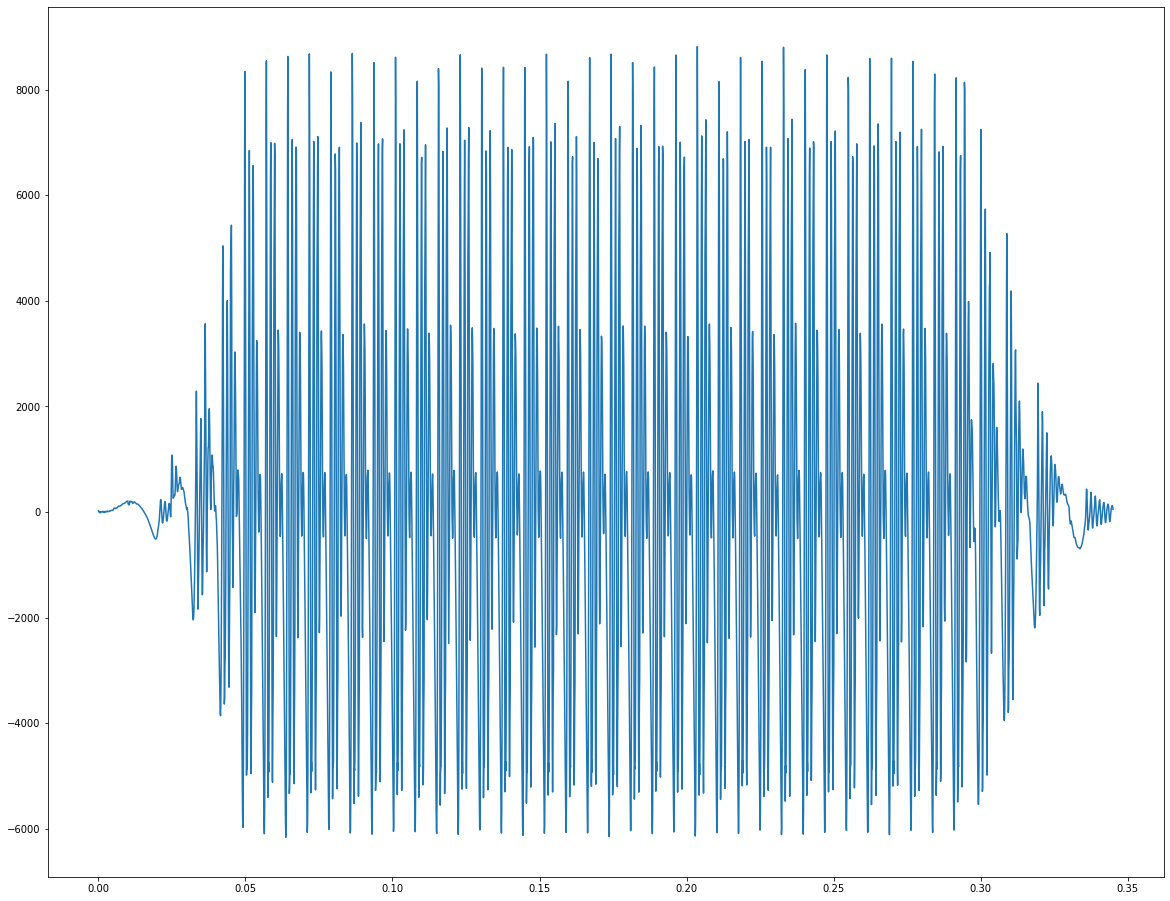

In [79]:
plt.plot(time,signal_x)

In [80]:
w,h = freqz(signal_x,1,fs=fs)
h_dB = 20 * np.log10(abs(h))


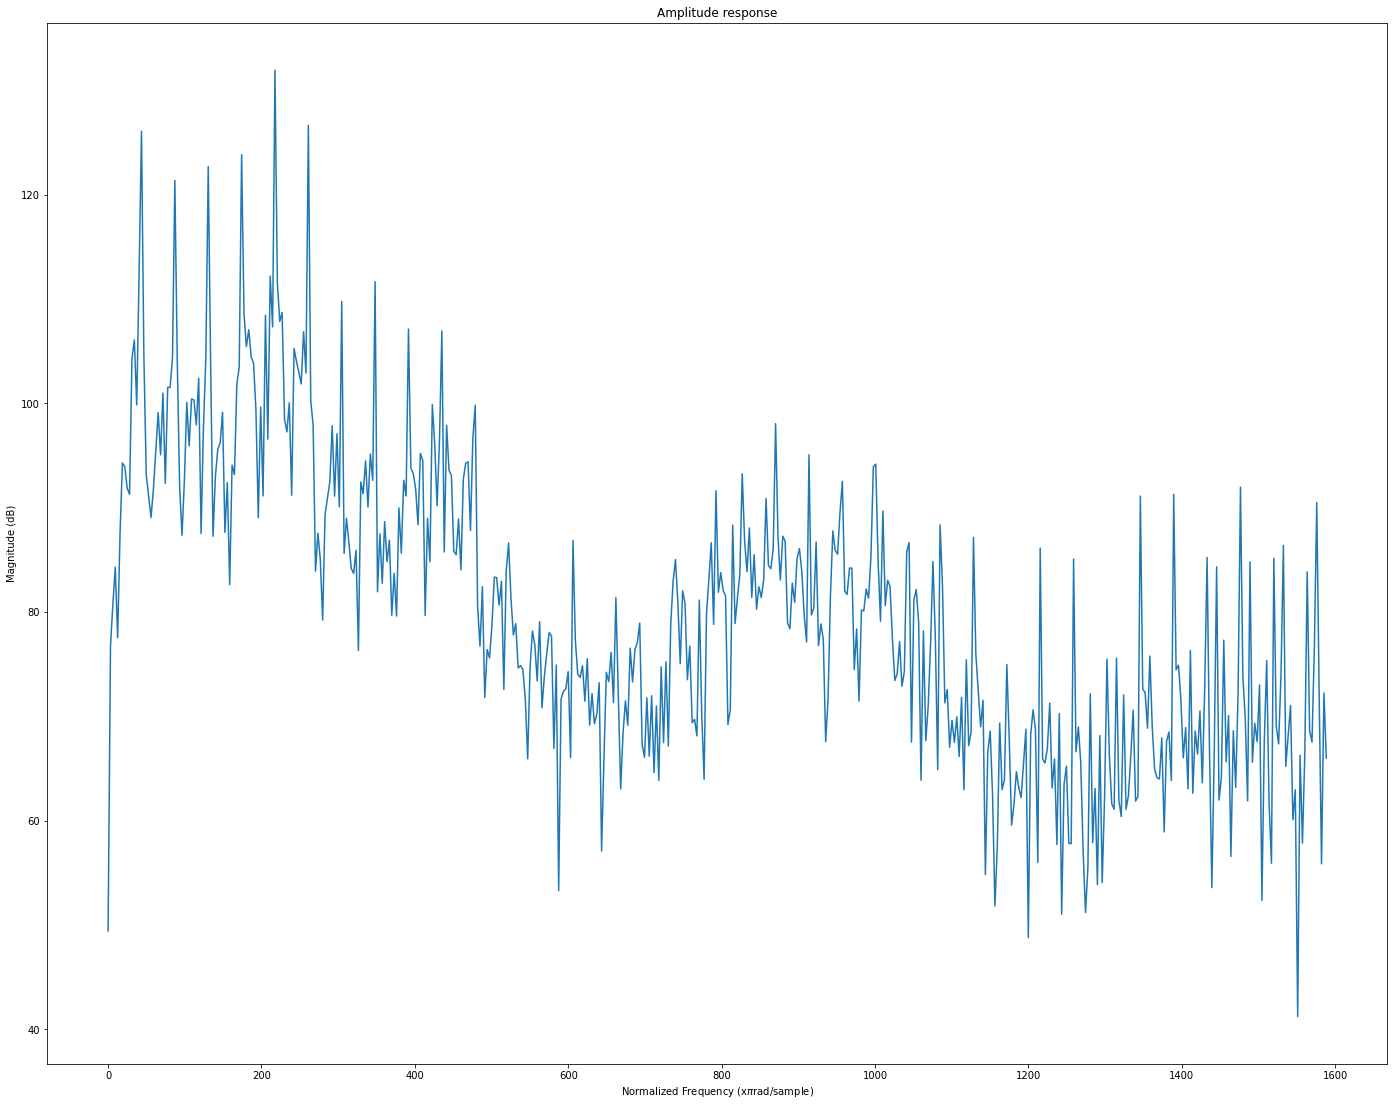

In [84]:
# plt.ylim([max(min(h_dB), -100), 5])
fig = plt.figure(1)
plt.ylabel("Magnitude (dB)")
plt.xlabel(r'Normalized Frequency (x$\pi$rad/sample)')
plt.title(r'Amplitude response')
plt.plot(w/np.pi, h_dB)
plt.tight_layout(pad=3, w_pad=0.1, h_pad=1)
plt.rcParams['figure.facecolor'] = 'white'
plt.savefig('result.png', facecolor=fig.get_facecolor(), transparent=True)
